<a href="https://colab.research.google.com/github/roy-sub/Time-Series-Air-Quality-Index-Prediction-and-Analysis-using-Multiple-Deep-Learning-Models/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

In [ ]:
# 321300
df = pd.read_csv('/content/air_quality_data_preprocessed')
df.shape

(401611, 33)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,16,2013,3,1,15,13.0,16.0,8.0,11.2000,800.0,...,90.0,10.833333,13.000000,7.437500,15.054638,5494.117647,90.0,6,5494.0,Severe
1,17,2013,3,1,16,11.0,22.0,6.0,15.4000,800.0,...,90.0,11.274510,13.529412,7.441176,15.301424,5494.117647,90.0,6,5494.0,Severe
2,18,2013,3,1,17,10.0,20.0,4.0,9.8000,800.0,...,90.0,11.574074,13.888889,7.305556,15.131900,5494.117647,90.0,6,5494.0,Severe
3,19,2013,3,1,18,11.0,20.0,6.0,12.6000,900.0,...,90.0,11.929825,14.210526,7.315789,15.164432,5494.117647,90.0,6,5494.0,Severe
4,20,2013,3,1,19,11.0,31.0,8.0,12.0053,1000.0,...,90.0,12.250000,15.050000,7.450000,15.156541,6082.352941,90.0,6,6082.0,Severe


In [ ]:
train = df[:321301]['AQI_calculated']
test = df[321301:401612]['AQI_calculated']

In [ ]:
# Normalizing training data # Converted into array as all the methods available are for arrays and not lists
train = np.asarray(train)
train_norm = np.reshape(train, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)

#Printing
for i in range(5):
    print(train_norm[i])

[0.08080912]
[0.08080912]
[0.08080912]
[0.08080912]
[0.09090597]


In [ ]:
train_norm = train_norm[train_norm!=0]

In [ ]:
# Normalizing testing data # Converted into array as all the methods available are for arrays and not lists
test = np.asarray(test)
test_norm = np.reshape(test, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)

#Printing
for i in range(5):
    print(test_norm[i])

[0.11111683]
[0.12121368]
[0.12121368]
[0.12121368]
[0.12121368]


In [ ]:
test_norm = test_norm[test_norm != 0]

In [ ]:
print(train_norm.shape)
print(test_norm.shape)

(319942,)
(80251,)


In [ ]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x),array(y)

In [ ]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
for i in range(5):
    print(X_split_train[i], y_split_train[i])

[0.08080912 0.08080912 0.08080912] 0.08080912150559791
[0.08080912 0.08080912 0.08080912] 0.09090596881653959
[0.08080912 0.08080912 0.09090597] 0.1010199876365135
[0.08080912 0.09090597 0.10101999] 0.11111683494745518
[0.09090597 0.10101999 0.11111683] 0.11111683494745518


In [ ]:
print(X_split_train.shape[0])
print(X_split_train.shape[1])
print(X_split_train.shape)

319939
3
(319939, 3)


In [ ]:
print(X_split_train[0])

[0.08080912 0.08080912 0.08080912]


In [ ]:
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train[i])

[[0.08080912]
 [0.08080912]
 [0.08080912]]
[[0.08080912]
 [0.08080912]
 [0.08080912]]
[[0.08080912]
 [0.08080912]
 [0.09090597]]
[[0.08080912]
 [0.09090597]
 [0.10101999]]
[[0.09090597]
 [0.10101999]
 [0.11111683]]


In [ ]:
print(X_split_train.shape)

(319939, 3, 1)


In [ ]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])

[0.11111683 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686


In [ ]:
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))
for i in range(5):
    print(X_split_test[i])

[[0.11111683]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]


In [ ]:
print(X_split_test.shape)

(80248, 3, 1)


In [ ]:
model_BiLSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(n_steps, n_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

model_BiLSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError(), metrics=['accuracy'])
model_BiLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 200)           81600     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 200)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 322,601
Trainable params: 322,601
Non-trai

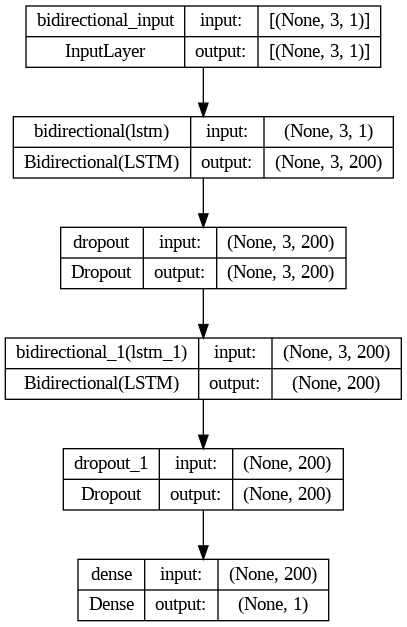

In [ ]:
tf.keras.utils.plot_model(model=model_BiLSTM, show_shapes=True)

In [ ]:
hist = model_BiLSTM.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

Epoch 1/10
9999/9999 [==============================] - 286s 27ms/step - loss: 5.1734e-04 - accuracy: 4.1570e-04 - val_loss: 3.9509e-04 - val_accuracy: 2.4923e-04
Epoch 2/10
9999/9999 [==============================] - 273s 27ms/step - loss: 4.5393e-04 - accuracy: 4.1570e-04 - val_loss: 3.6554e-04 - val_accuracy: 2.4923e-04
Epoch 3/10
9999/9999 [==============================] - 266s 27ms/step - loss: 4.4299e-04 - accuracy: 4.1570e-04 - val_loss: 3.9028e-04 - val_accuracy: 2.4923e-04
Epoch 4/10
9999/9999 [==============================] - 268s 27ms/step - loss: 4.3840e-04 - accuracy: 4.1570e-04 - val_loss: 3.6058e-04 - val_accuracy: 2.4923e-04
Epoch 5/10
9999/9999 [==============================] - 266s 27ms/step - loss: 4.3398e-04 - accuracy: 4.1570e-04 - val_loss: 3.6165e-04 - val_accuracy: 2.4923e-04
Epoch 6/10
9999/9999 [==============================] - 265s 26ms/step - loss: 4.3301e-04 - accuracy: 4.1570e-04 - val_loss: 3.9174e-04 - val_accuracy: 2.4923e-04
Epoch 7/10
9999/9999 [

In [ ]:
yhat = model_BiLSTM.predict(X_split_test)
for i in range(5):
    print(yhat[i])

2508/2508 [==============================] - 21s 7ms/step
[0.11884636]
[0.11828592]
[0.11828592]
[0.11828592]
[0.11828592]


In [ ]:
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)

MSE: 0.00056


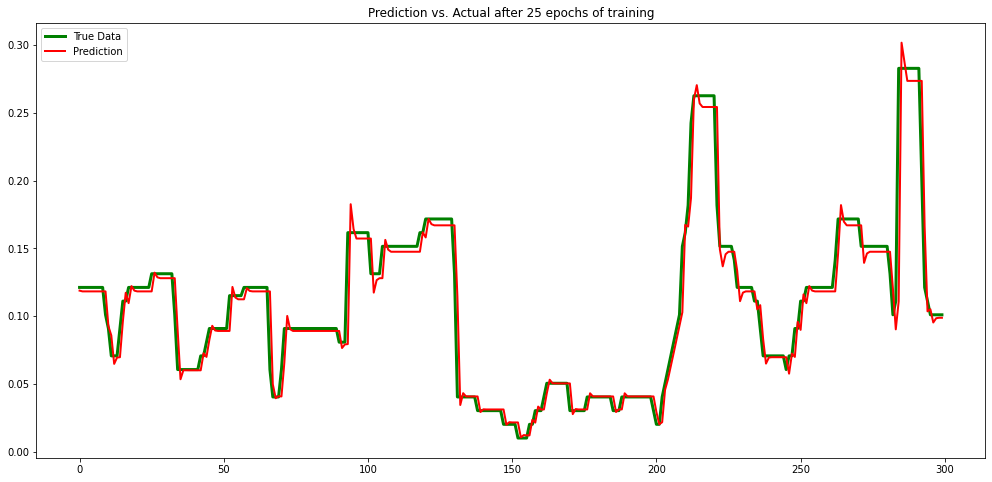

Root Mean Squared Error: 0.0238
R2 score : 0.96


In [ ]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 25 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

plot_predicted(yhat[:300,], y_split_test[:300,])
rmse = sqrt(mean_squared_error(y_split_test, yhat))
print('Root Mean Squared Error: {:.4f}'.format(rmse))
print("R2 score : %.2f" % r2_score(y_split_test, yhat))

In [ ]:
_, train_acc = model_BiLSTM.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = model_BiLSTM.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.00042, Test: 0.00025


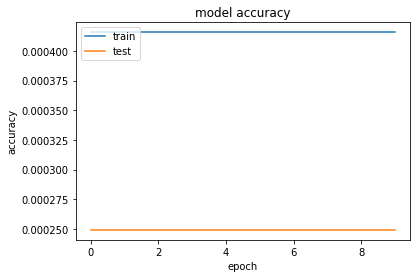

In [ ]:
# Resolve the issue

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

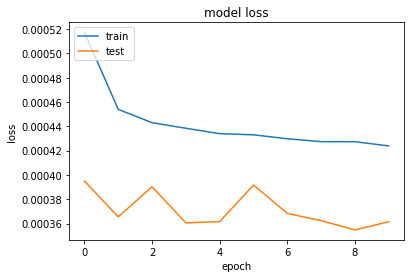

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()